In [1]:
import numpy as np
from scipy import linalg
from qiskit import QuantumCircuit
from qiskit.quantum_info.operators import Operator

from utils_decompose import global_phase_gate, ucry_decomposition_2x2_symmetric, ucry_decomposition_optimize
from utils_block_encode import is_unitary, transfer_matrix
from utils import universal_be
from utils_linlin import linlin_2x2_symmetric_optimize

In [2]:
a,b = np.random.rand()*2-1,np.random.rand()*2-1

M = 0.5*np.matrix([[a,b],[b,a]])
print("Matrix:\n",M)
print("-> untary:", is_unitary(M))

enlarge_a = 0.5*np.matrix([[a,b,a,-b],
                           [b,a,-b,a],
                           [a,-b,a,b],
                           [-b,a,b,a]])

c,d = np.sqrt(1-a**2),np.sqrt(1-b**2)
enlarge_b = 0.5*np.matrix([[c,d,c,-d],
                           [d,c,-d,c],
                           [c,-d,c,d],
                           [-d,c,d,c]])

enlarge_M = np.eye(8)
enlarge_M[:4,:4] = enlarge_a
enlarge_M[:4,4:] = -enlarge_b
enlarge_M[4:,:4] = enlarge_b
enlarge_M[4:,4:] = enlarge_a

print("Enlarge:\n",np.round(enlarge_M,3))
print("-> untary:", is_unitary(enlarge_M))

Matrix:
 [[-0.36391889 -0.07510659]
 [-0.07510659 -0.36391889]]
-> untary: False
Enlarge:
 [[-0.364 -0.075 -0.364  0.075 -0.343 -0.494 -0.343  0.494]
 [-0.075 -0.364  0.075 -0.364 -0.494 -0.343  0.494 -0.343]
 [-0.364  0.075 -0.364 -0.075 -0.343  0.494 -0.343 -0.494]
 [ 0.075 -0.364 -0.075 -0.364  0.494 -0.343 -0.494 -0.343]
 [ 0.343  0.494  0.343 -0.494 -0.364 -0.075 -0.364  0.075]
 [ 0.494  0.343 -0.494  0.343 -0.075 -0.364  0.075 -0.364]
 [ 0.343 -0.494  0.343  0.494 -0.364  0.075 -0.364 -0.075]
 [-0.494  0.343  0.494  0.343  0.075 -0.364 -0.075 -0.364]]
-> untary: True


In [3]:
import sympy as sp

aa,bb = sp.symbols('a'),sp.symbols('b')
ii = np.eye(2)
c1 = np.matrix([[1,0,0,0],[0,0,0,1],[0,0,1,0],[0,1,0,0]])
c2 = np.matrix([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])
h = np.matrix([[1,1],[1,-1]])/np.sqrt(2)

def sym_ry(x): return np.matrix([[sp.cos(x/2),-sp.sin(x/2)],[sp.sin(x/2),sp.cos(x/2)]])

# difusser
T1 = np.kron(np.kron(ii,h),ii)
# oracle_c
T2 = np.kron(ii,c2)
# oracle_a
T3 = np.kron(np.kron(sym_ry(bb/2),ii),ii)
T4 = np.kron(c1,ii)
T5 = np.kron(np.kron(sym_ry(-bb/2),ii),ii)
T6 = np.kron(np.kron(sym_ry(aa),ii),ii)

TT = T1@T6@T4@T5@T4@T3@T2@T1

sp.simplify(TT)

[[0.5*cos(a/2), 0.5*cos(a/2 + b/2), 0.5*cos(a/2), -0.5*cos(a/2 + b/2), -0.5*sin(a/2), -0.5*sin(a/2 + b/2), -0.5*sin(a/2), 0.5*sin(a/2 + b/2)], [0.5*cos(a/2 + b/2), 0.5*cos(a/2), -0.5*cos(a/2 + b/2), 0.5*cos(a/2), -0.5*sin(a/2 + b/2), -0.5*sin(a/2), 0.5*sin(a/2 + b/2), -0.5*sin(a/2)], [0.5*cos(a/2), -0.5*cos(a/2 + b/2), 0.5*cos(a/2), 0.5*cos(a/2 + b/2), -0.5*sin(a/2), 0.5*sin(a/2 + b/2), -0.5*sin(a/2), -0.5*sin(a/2 + b/2)], [-0.5*cos(a/2 + b/2), 0.5*cos(a/2), 0.5*cos(a/2 + b/2), 0.5*cos(a/2), 0.5*sin(a/2 + b/2), -0.5*sin(a/2), -0.5*sin(a/2 + b/2), -0.5*sin(a/2)], [0.5*sin(a/2), 0.5*sin(a/2 + b/2), 0.5*sin(a/2), -0.5*sin(a/2 + b/2), 0.5*cos(a/2), 0.5*cos(a/2 + b/2), 0.5*cos(a/2), -0.5*cos(a/2 + b/2)], [0.5*sin(a/2 + b/2), 0.5*sin(a/2), -0.5*sin(a/2 + b/2), 0.5*sin(a/2), 0.5*cos(a/2 + b/2), 0.5*cos(a/2), -0.5*cos(a/2 + b/2), 0.5*cos(a/2)], [0.5*sin(a/2), -0.5*sin(a/2 + b/2), 0.5*sin(a/2), 0.5*sin(a/2 + b/2), 0.5*cos(a/2), -0.5*cos(a/2 + b/2), 0.5*cos(a/2), 0.5*cos(a/2 + b/2)], [-0.5*sin(a

In [4]:
t1 = 2*np.arccos(a)
t2 = 2*np.arccos(b) - t1

Matrix:
 [[-0.364 -0.075]
 [-0.075 -0.364]]
-> untary: False
Circuit matrix (upper left block):
 [[-0.364+0.j -0.075+0.j -0.364+0.j  0.075+0.j]
 [-0.075+0.j -0.364+0.j  0.075+0.j -0.364+0.j]
 [-0.364+0.j  0.075+0.j -0.364+0.j -0.075+0.j]
 [ 0.075+0.j -0.364+0.j -0.075+0.j -0.364+0.j]]
-> untary: True
Successfully encode matrix using Block Encoding: True


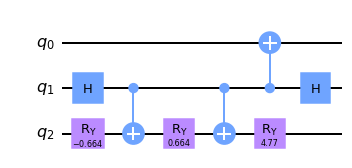

In [5]:
qc = QuantumCircuit(3)

qc.h(1)
# qc.cx(1,0)

# cry
qc.ry(t2/2,2)
qc.cx(1,2)
qc.ry(-t2/2,2)
qc.cx(1,2)

qc.ry(t1,2)

qc.cx(1,0)
qc.h(1)

print("Matrix:\n",np.round(M,3)[:2,:2])
print("-> untary:", is_unitary(M))

print("Circuit matrix (upper left block):\n",np.round(np.matrix(Operator(qc)),3)[:4,:4])
print("-> untary:", is_unitary(Operator(qc)))

print("Successfully encode matrix using Block Encoding:",np.allclose(M[:2,:2], np.matrix(Operator(qc))[:2,:2]))
qc.draw(output="mpl")

Matrix:
 [[-0.364 -0.075]
 [-0.075 -0.364]]
-> untary: False
Circuit matrix (upper left block):
 [[-0.364+0.j -0.075+0.j -0.029-0.j  0.928-0.j]
 [-0.075+0.j -0.364+0.j  0.928-0.j -0.029-0.j]
 [-0.928+0.j  0.029+0.j -0.075+0.j -0.364+0.j]
 [ 0.029+0.j -0.928+0.j -0.364+0.j -0.075+0.j]]
-> untary: True
Successfully encode matrix using Block Encoding: True


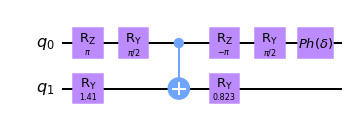

In [6]:
qc = QuantumCircuit(2)

phase = 0
phase = universal_be(qc,M,range(2),phase)

global_phase_gate(qc,phase,0)

print("Matrix:\n",np.round(M,3)[:2,:2])
print("-> untary:", is_unitary(M))

print("Circuit matrix (upper left block):\n",np.round(np.matrix(Operator(qc)),3))
print("-> untary:", is_unitary(Operator(qc)))

print("Successfully encode matrix using Block Encoding:",np.allclose(M[:2,:2], np.matrix(Operator(qc))[:2,:2]))
qc.draw(output="mpl",fold=-1)

Matrix:
 [[-0.364 -0.075]
 [-0.075 -0.364]]
-> untary: False
Circuit matrix (upper left block):
 [[-0.364+0.j -0.075+0.j  0.029+0.j -0.928+0.j]
 [-0.075+0.j -0.364+0.j -0.928+0.j  0.029+0.j]
 [ 0.928+0.j -0.029+0.j -0.075+0.j -0.364+0.j]
 [-0.029+0.j  0.928+0.j -0.364+0.j -0.075+0.j]]
-> untary: True
Successfully encode matrix using Block Encoding: True


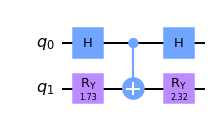

In [7]:
qc = QuantumCircuit(2)

qc.h(0)

D_optimized = linlin_2x2_symmetric_optimize(M)
ucry_decomposition_optimize(qc,2,np.real(D_optimized)@transfer_matrix(2),range(2))

qc.h(0)

print("Matrix:\n",np.round(M,3)[:2,:2])
print("-> untary:", is_unitary(M))

print("Circuit matrix (upper left block):\n",np.round(np.matrix(Operator(qc)),3)[:4,:4])
print("-> untary:", is_unitary(Operator(qc)))

print("Successfully encode matrix using Block Encoding:",np.allclose(M[:2,:2], np.matrix(Operator(qc))[:2,:2]))
qc.draw(output="mpl",fold=-1)